# Logistic Regression

In [1]:
import torch
import tqdm
import seaborn as sns
import matplotlib.pyplot  as plt
import os
import numpy as np
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import random 
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.linear_model import LogisticRegression

In [2]:
DATASET_SIZE = "xs"
DATASET_TYPE = "waveform"

DATASET_FOLDER = f"./data/{DATASET_TYPE}"

DATASET_NUM_SAMPLES_PER_SECOND = 8000
DATASET_NUM_CHANNELS = 1

DATASET_NAME = f"fma_{DATASET_SIZE}_resampled_{DATASET_NUM_SAMPLES_PER_SECOND}_rechanneled_{DATASET_NUM_CHANNELS}"

dataset_path = f"{DATASET_FOLDER}/{DATASET_NAME}"

In [4]:
audio_path_list = []

for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        file_audio_path = os.path.join(path, name)
        if name != '.DS_Store':
            audio_path_list.append(file_audio_path)

audio_path_list = sorted(audio_path_list , reverse= True) 

In [6]:
single_tensors = []
labels = []
for p in audio_path_list:
    single_tensors.append(torch.load(p))
    labels.append(p.split("/")[-2])
stacked_single_tensors = torch.cat(single_tensors).numpy()

In [7]:
data = pd.DataFrame(stacked_single_tensors)
data.insert(0, "Label", labels, True)

In [79]:
def train_test_split( dataset , perc_train , set_seed = 69):
    train = dataset.sample(frac= perc_train,random_state = set_seed )
    test  = dataset.drop(train.index)
    return (train , test )
#####   
train_dataset , test_dataset = train_test_split( data , perc_train = .85)

In [ ]:
X = train_dataset.iloc[: , 1:]      # ALL THE DATA POINTS
y = train_dataset.iloc[: , :1]      # ALL THE LABELS

std_slc = StandardScaler()          # STANDARDIZE

pca = decomposition.PCA()           # PCA

logistic_Reg = linear_model.LogisticRegression()    # LINEAR REGRESSION

### 
pipe = Pipeline(steps=[('std_slc', std_slc),
                ('pca', pca),
                ('logistic_Reg', logistic_Reg)])


n_components = list(range( int(.01 * X.shape[0]) ,  int(.25 * X.shape[0]) , 1))    # NUMBER OF PCA WE TEST
# WE TRIED DIFFERENTS COMBINATIONS AND WE ENDED UP DISCOVERING THAT FEW PRINCIPAL COMPONENTS WERE ENOUGH
# WE NOW TEST ONLY ON THE FIRST 25% OF THE POSSIBLE NUMBER OF PC's.

C = [2., 20.]      # NUMBER OF C VALUE WE TEST

penalty = ['l1', 'l2']    # PENALTY WE TEST

# COMBINE ALL IN A DICTIONARY
parameters = dict(pca__n_components=n_components,
                    logistic_Reg__C=C,
                    logistic_Reg__penalty=penalty)


In [ ]:
### RUN THE KFOLD CROSS VALIDATION TO DISCOVER THE BEST HYPERPARAMETERS
clf = GridSearchCV(pipe, parameters, n_jobs=2, verbose=3, cv=3)
clf.fit(X, y)

In [ ]:
print('Best Penalty:', clf.best_estimator_.get_params()['logistic_Reg__penalty'])
print('Best C:', clf.best_estimator_.get_params()['logistic_Reg__C'])
print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print(); print(clf.best_estimator_.get_params()['logistic_Reg'])

Best Penalty: l2
Best C: 2.0
Best Number Of Components: 52

LogisticRegression(C=2.0)


In [ ]:
# WE DON'T KNOW WHY IS HERE
#CV_result = cross_val_score(clf , X , y , cv = 3 , n_jobs=2, verbose=3)

## Run the Logistcics regression with the best hyperparameters

In [ ]:
X_train = train_dataset.iloc[: , 1:]      # ALL THE DATA POINTS for the training set 
y_train = train_dataset.iloc[: , :1]      # ALL THE LABELSfor the training set 

X_test =  test_dataset.iloc[: , 1:]       # ALL THE DATA POINTS for the test set 
y_test =  test_dataset.iloc[: , :1]       # ALL THE LABELS for the test set

# [TODO]  do not arcoding but with the best hyperparameter

pca = PCA(n_components= 11)               # PCA with the best number of components
X_train_pca =  pd.DataFrame(pca.fit_transform(X_train))   # Transform the train dataset in pc
X_test_pca  =  pd.DataFrame(pca.fit_transform(X_test ))   # Transform the test  dataset in pc

### RUN THE LOGISTIC REGRESSION

logistic = LogisticRegression(penalty= 'l2'  , C = 2)
logistic.fit( X_train_pca  , y_train )

### TEST THE MODEL
LogisticPredictions = logistic.predict( X_test_pca )

In [143]:
Logistic_Accuracy = logistic.score(  X_test_pca , y_test ) 
Logistic_Accuracy ="{: .0%}".format(Logistic_Accuracy)
print(f"The accuracy of the logistic model is:{Logistic_Accuracy}")

The accuracy of the logistic model is: 21%


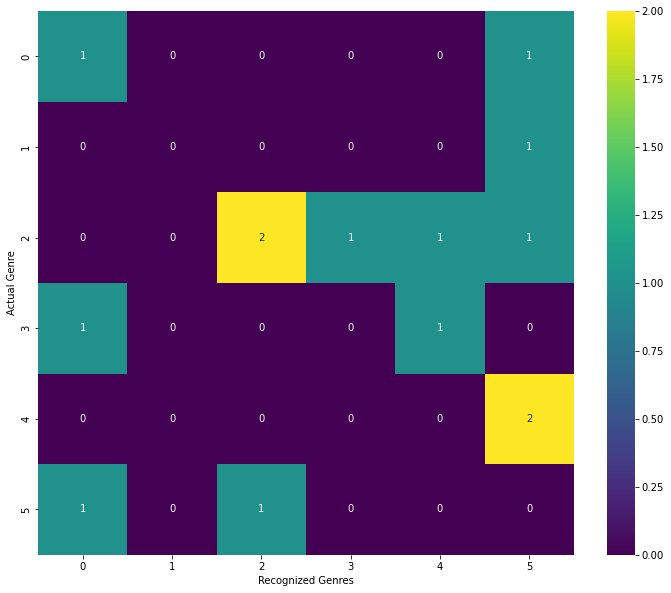

In [159]:
### CONFUSION MATRIX
confusion = metrics.confusion_matrix( y_test , LogisticPredictions)
plt.figure(figsize=(12,10))
sns.heatmap(confusion , annot= True , fmt = 'd' , cmap= "viridis")
plt.xlabel("Recognized Genres")
plt.ylabel("Actual Genre")
plt.show()

---
MEL SPECTROGRAM

---


In [41]:
DATASET_SIZE = "xs"
DATASET_TYPE = "mel_spectrograms"

DATASET_FOLDER = f"./data/{DATASET_TYPE}"

DATASET_NUM_SAMPLES_PER_SECOND = 8000
DATASET_NUM_CHANNELS = 1

DATASET_NAME = f"fma_{DATASET_SIZE}_resampled_{DATASET_NUM_SAMPLES_PER_SECOND}_rechanneled_{DATASET_NUM_CHANNELS}"

dataset_path = f"{DATASET_FOLDER}/{DATASET_NAME}"

In [52]:
## WE HAVE CHANGED THE FILE NAME
audio_path_list = []

for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        file_audio_path = os.path.join(path, name)
        if name != '.DS_Store':
            audio_path_list.append(file_audio_path)

audio_path_list = sorted(audio_path_list , reverse= True) 

In [64]:
single_tensors_mel = []
labels_mel = []
for p in audio_path_list:
    single_tensors_mel.append(torch.load(p))
    labels_mel.append(p.split("/")[-2])
stacked_single_tensors_mel = torch.cat(single_tensors_mel).numpy()

In [72]:
a = stacked_single_tensors_mel.reshape(90 , 128 * 1860 )

In [73]:
data_mel = pd.DataFrame(a)
data_mel.insert(0, "Label", labels_mel, True)

(90, 238080)

In [189]:
data_train_mel , data_test_mel = train_test_split(data_mel , perc_train= 0.78)

In [ ]:
X_train_mel = data_train_mel.iloc[: , 1:] # ALL THE DATA POINTS for the training set 
y_train_mel = data_train_mel.iloc[: , :1]  # ALL THE LABELSfor the training set 


X_test_mel =  data_test_mel.iloc[: , 1:]       # ALL THE DATA POINTS for the test set 
y_test_mel =  data_test_mel.iloc[: , :1]       # ALL THE LABELS for the test set




pca = PCA(n_components= 3)               # PCA with the best number of components
X_train_pca_mel =  pd.DataFrame(pca.fit_transform(X_train_mel))   # Transform the train dataset in pc
X_test_pca_mel  =  pd.DataFrame(pca.fit_transform(X_test_mel ))   # Transform the test  dataset in pc


logistic = LogisticRegression(penalty= 'l2'  , C = 2)
logistic.fit( X_train_pca_mel  , y_train_mel )

### TEST THE MODEL
LogisticPredictions = logistic.predict( X_test_pca_mel )


Logistic_Accuracy = logistic.score(  X_test_pca_mel , y_test_mel ) 
Logistic_Accuracy ="{: .0%}".format(Logistic_Accuracy)
print(f"The accuracy of the logistic model is:{Logistic_Accuracy}")

In [ ]:
## [TODO] Nice plots